# Heart Disease Prediction
### Context:
The World Health Organization as well as the Global Burden of Disease study reported cardiovascular disease (CVD) as the leading cause of death globally. In industrialized countries, the rate is approximately 1 in 4 deaths, while in less developed countries the rate is even higher. 
### Objective:
I will use this dataset to build a machine learning model that can predict the risk of heart disease based on the provided features. The goal is to create a model that can accurately classify individuals as having or not having heart disease, which can help in early diagnosis and treatment.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score

%matplotlib inline

In [3]:
heart_data = pd.read_csv('heart.csv')
heart_data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


This dataset has 918 patient entries with 12 features:  
***1. Age***: Patient's age in years.  
***2. Sex***: Patient's gender (M/F).  
***3. ChestPainType***: Type of chest pain (TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic).  
***4. RestingBP***: Resting blood pressure (mmHg).  
***5. Cholesterol*** Cholesterol level (mg/dL).  
***6. FastingBS***: Fasting blood sugar (1 if >120mg/dL, otherwise 0).  
***7. Resting ECG***: Resting electrocardiogram results (Normal: Normal, ST: Having ST-T wave abnormality, LVH: showing probable/definite left ventricular hypertrophy).  
***8. MaxHR***: Maximum heart rate achieved during exercise.  
***9. ExerciseAngina***: Exercised-induced angina (Y/N).  
***10. Oldpeak***: ST depression induced by exercise relative to rest.  
***11. ST_Slope***: ST segment slope during stress test (Up, Flat, Down).  
***12. HeartDisease***: Target variable (1=heart disease, 0=no heart disease).  

In [5]:
heart_data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


RestingBP and Cholesterol both have minimum values of 0 which is physiologically impossible. I will examine further to see if there is missing data.

In [6]:
# Subset heart_data to find rows with RestingBP or Cholesterol equal to 0
restingbp_missing_subset = heart_data[heart_data['RestingBP'] == 0]
cholesterol_missing_subset = heart_data[heart_data['Cholesterol'] == 0]
print(f"Entries missing RestingBP data: {len(restingbp_missing_subset)}")
print(f"Entries missing Cholesterol data: {len(cholesterol_missing_subset)}")

Entries missing RestingBP data: 1
Entries missing Cholesterol data: 172


One patient has a RestingBP of 0, which is clearly a data entry error or missing value. Cholesterol, however, has 172 missing values. This accounts for approximately 19% of the dataset and will necessitate intervention.  
***Data Cleaning Plan***:  
1. Remove the patient record with RestingBP = 0.  
2. Replace missing Cholesterol values with the median Cholesterol value, calculated separately for patients with and without heart disease.

In [7]:
heart_cleaned = heart_data.copy()

# Remove the patient record with RestingBP = 0
heart_cleaned = heart_cleaned[heart_cleaned['RestingBP'] != 0]

# Create a mask for patients without heart disease
heartdisease_mask = heart_cleaned['HeartDisease'] == 1

# Get cholesterol values for patients with and without heart disease
cholesterol_wo_hd = heart_cleaned.loc[~heartdisease_mask, 'Cholesterol']
cholesterol_w_hd = heart_cleaned.loc[heartdisease_mask, 'Cholesterol']

# Replace missing Cholesterol values with the median for the respective groups
heart_cleaned.loc[~heartdisease_mask, 'Cholesterol'] = cholesterol_wo_hd.replace(0, cholesterol_wo_hd.median())
heart_cleaned.loc[heartdisease_mask, 'Cholesterol'] = cholesterol_w_hd.replace(0, cholesterol_w_hd.median())

# Verify that there are no more missing values in the Cholesterol column
print(f"Cholesterol null values: {heart_cleaned['Cholesterol'].isnull().sum()}")
print(heart_cleaned.Cholesterol.describe())

Cholesterol null values: 0
count    917.000000
mean     239.700109
std       54.352727
min       85.000000
25%      214.000000
50%      225.000000
75%      267.000000
max      603.000000
Name: Cholesterol, dtype: float64


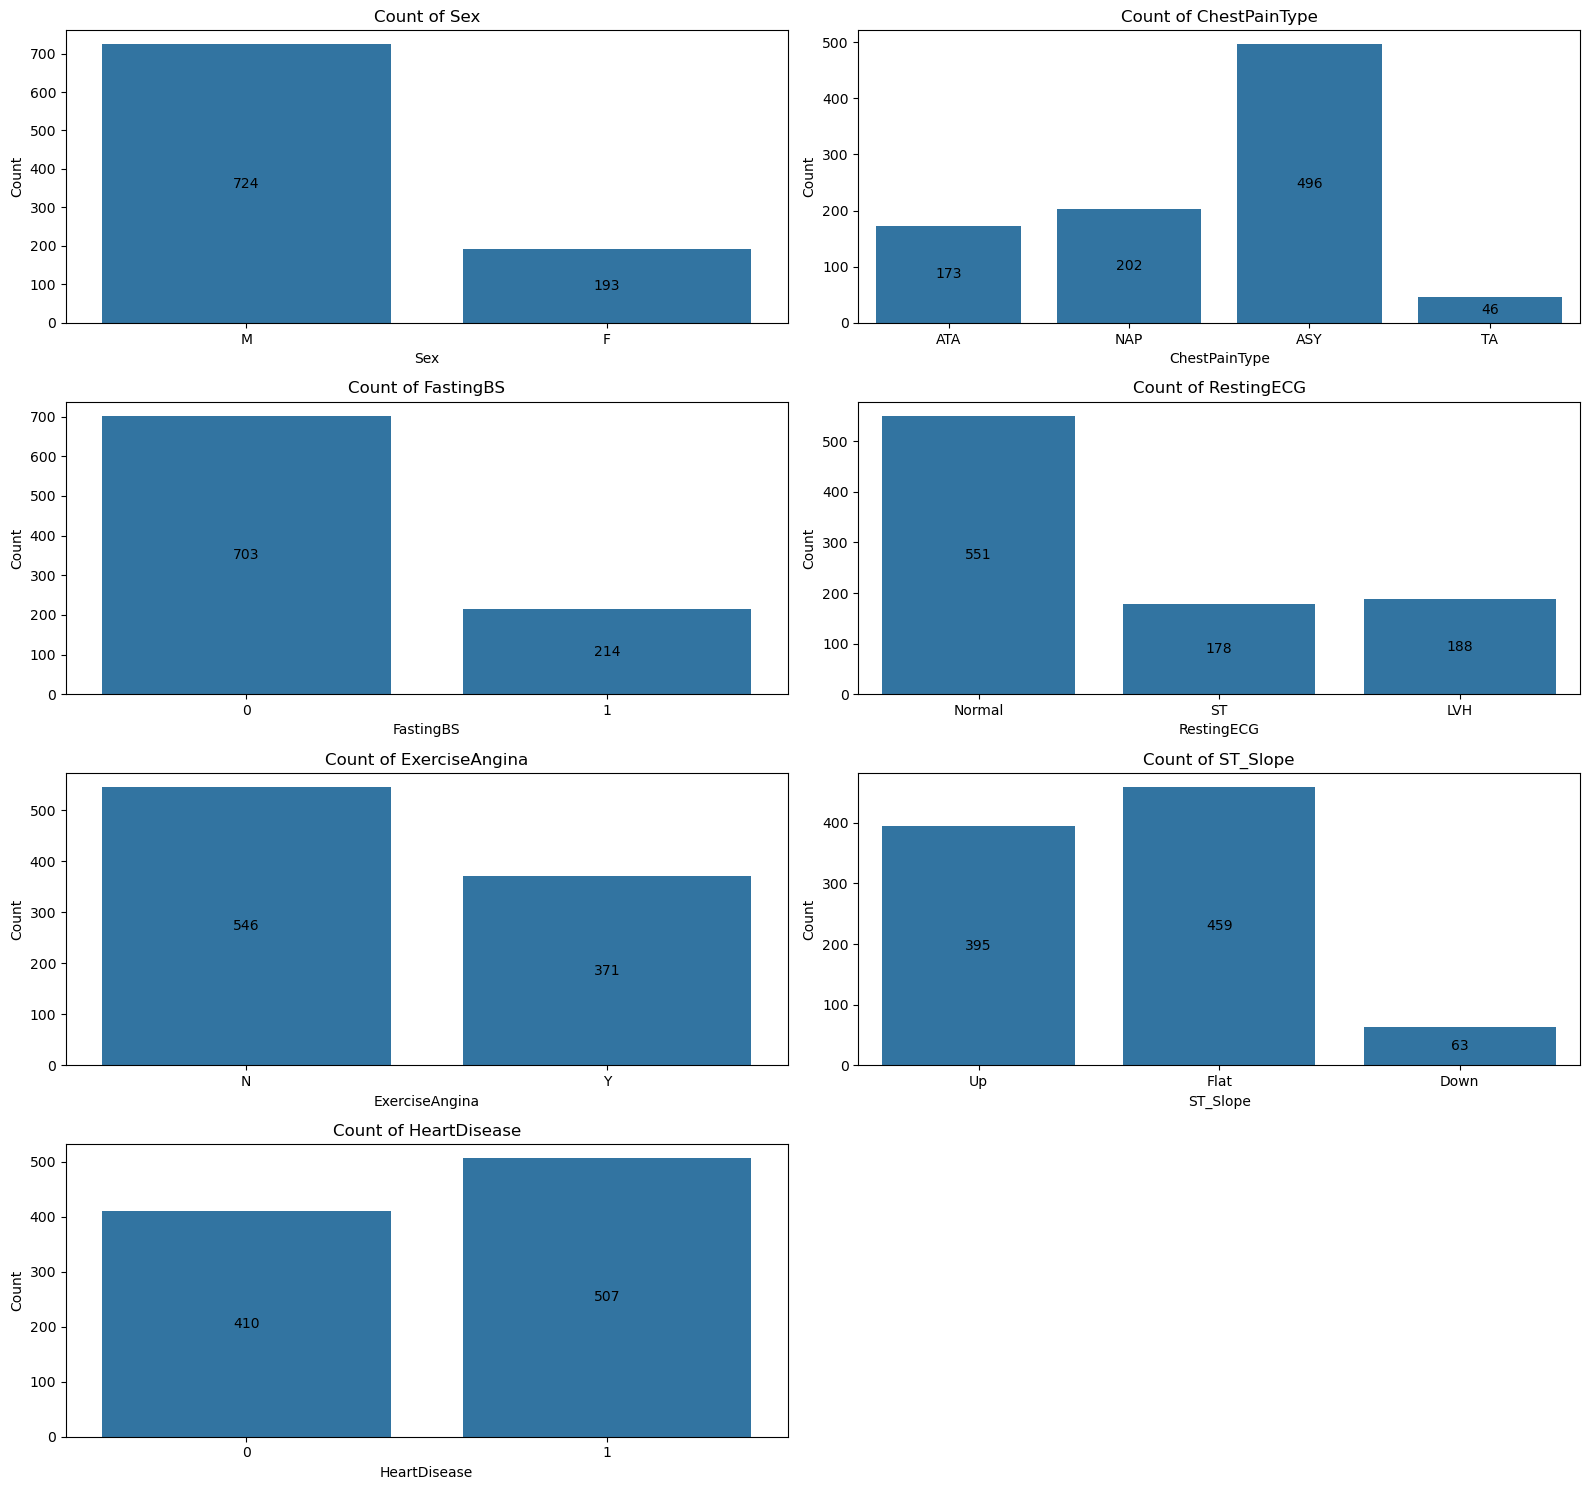

In [8]:
categorical_features = ['Sex', 'ChestPainType','FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']

fig = plt.figure(figsize=(16,15))

for i, col in enumerate(categorical_features, 1):
    ax = fig.add_subplot(4, 2, i)
    sns.countplot(x=heart_cleaned[col], ax=ax)
    for container in ax.containers:
        ax.bar_label(container, label_type='center')
    ax.set_title(f'Count of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

From the countplots above, we learn the following about the distribution of the categorical variables:  
***Sex***: This dataset contains significantly more males (725) than females (193).  
***ChestPainType***: Over half of the patients experienced asymptomatic chest pain (54%), while approximately 20% experiences atypical angina or non-anginal pain. 5% of patients are recorded with typical angina.  
***FastingBS***: 76.69% of patients did not experience elevated fasting blood sugar.  
***RestingECG***: Over half of the patients experienced normal resting ECG.  
***ExerciseAngina***: Approximately 1 in 3 patients experience exercise-induced angina.  
***ST_Slope***: "Flat" and "Up" are the most common ST slopes, with less than 7% experiencing "Down" ST slopes.  
***HeartDisease***: The target variable is reasonably balanced, with slightly more postitive cases.  

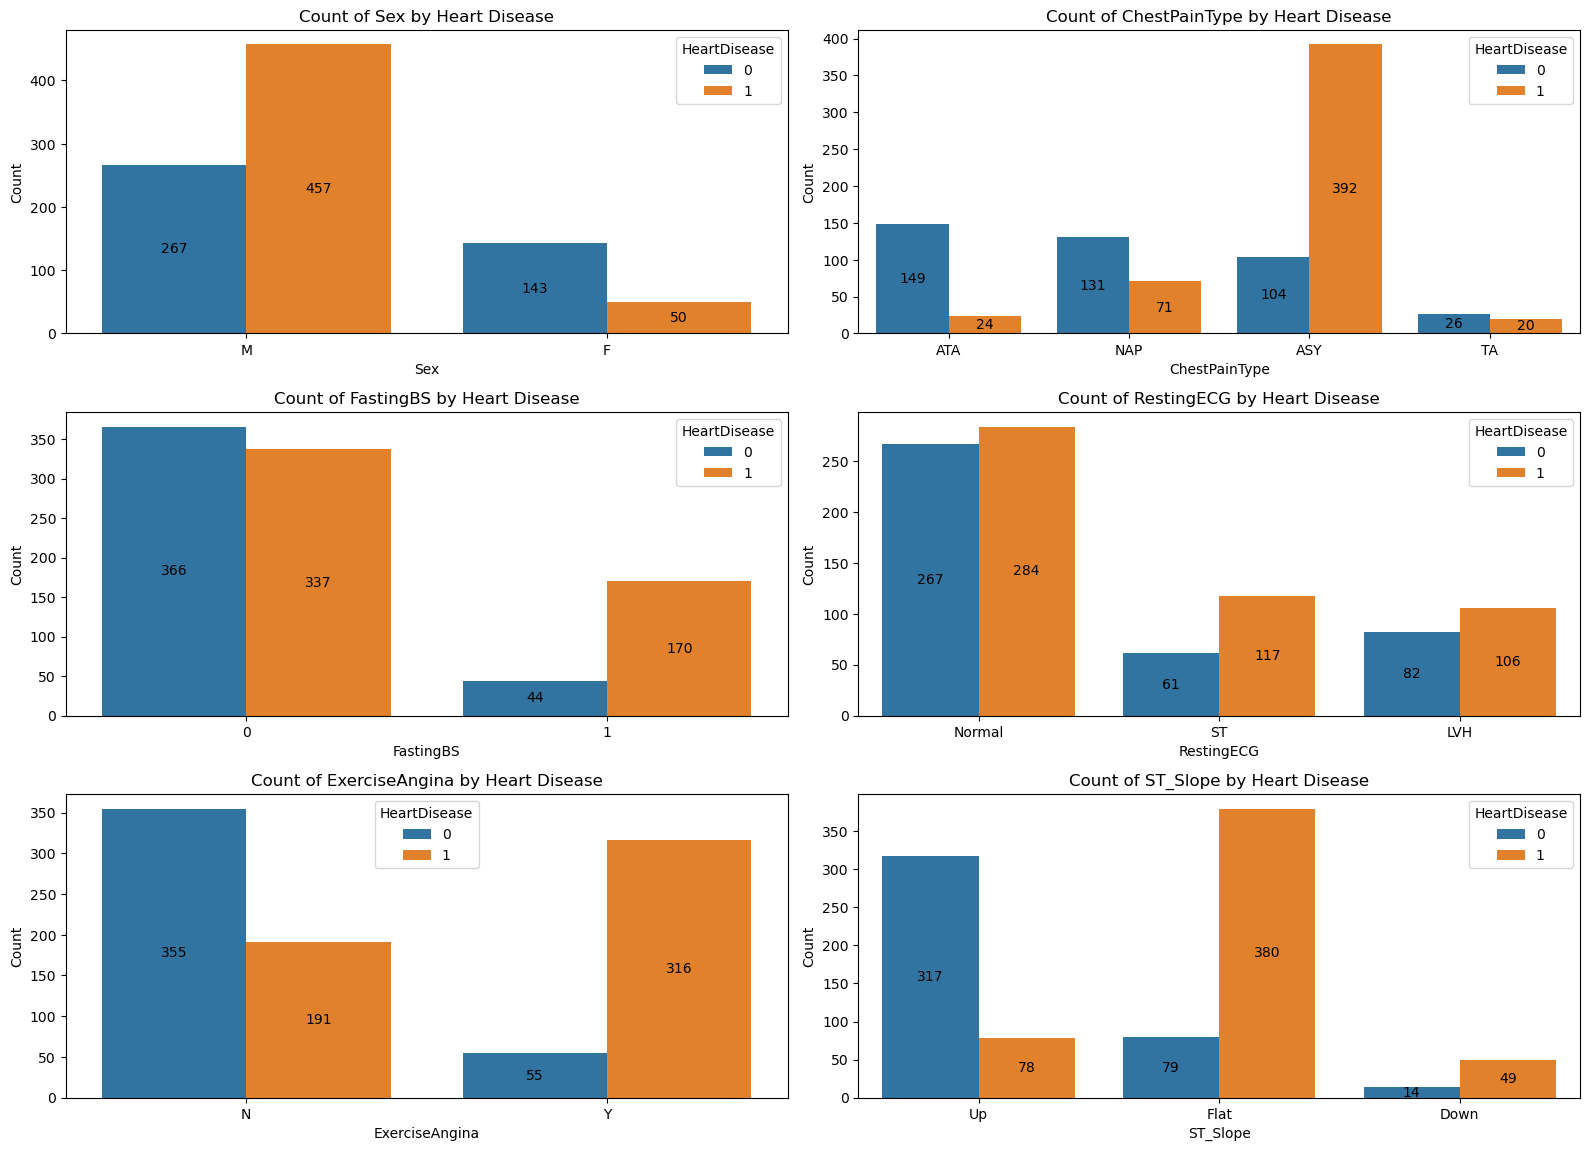

In [9]:
fig = plt.figure(figsize=(16, 15))

for i, col in enumerate(categorical_features[:-1]):
    ax = fig.add_subplot(4, 2, i+1)
    sns.countplot(data=heart_cleaned, x=col, hue='HeartDisease', ax=ax)
    for container in ax.containers:
        ax.bar_label(container, label_type='center')
    ax.set_title(f'Count of {col} by Heart Disease')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

Analyzing the categorical variables relative to the presence of heart disease revealed the following patterns:  
***Sex***: Males have a higher prevalence of heart disease in this dataset.  
***ChestPainType***: Asymptomatic chest pain is strongly associated with heart disease.  
***FastingBS***: Elevated fasting blood sugar is associated with heart disease.  
***RestingECG***: ST wave abnormalities are associated with heart disease prevalence.  
***ExerciseAngina***: Exercise-induced angina is strongly associated with heart disease.  
***ST_Slope***: "Flat" ST slope is strongly associated with heart disease while "Up" shows a strong negative association with heart disease.

In [10]:
# One-hot encode categorical features
heart_cleaned = pd.get_dummies(heart_cleaned, drop_first=True)
heart_cleaned.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,True,False,True,False,True,False,False,False,True


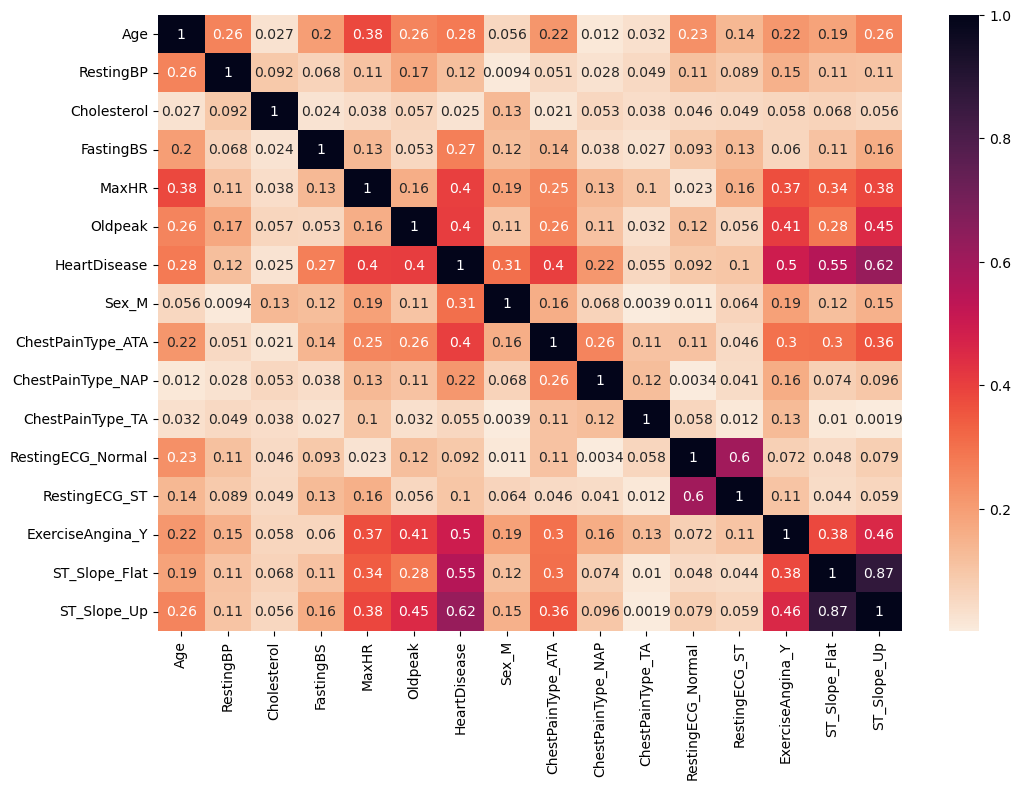

In [11]:
correlations = abs(heart_cleaned.corr())
plt.figure(figsize=(12,8))
sns.heatmap(correlations, annot=True, cmap="rocket_r")
plt.show()

Features with high correlation to HeartDisease:
MaxHR
Oldpeak
Sex_M
ChestPainType_ATA
ExerciseAngina_Y
ST_Slope_Flat
ST_Slope_Up


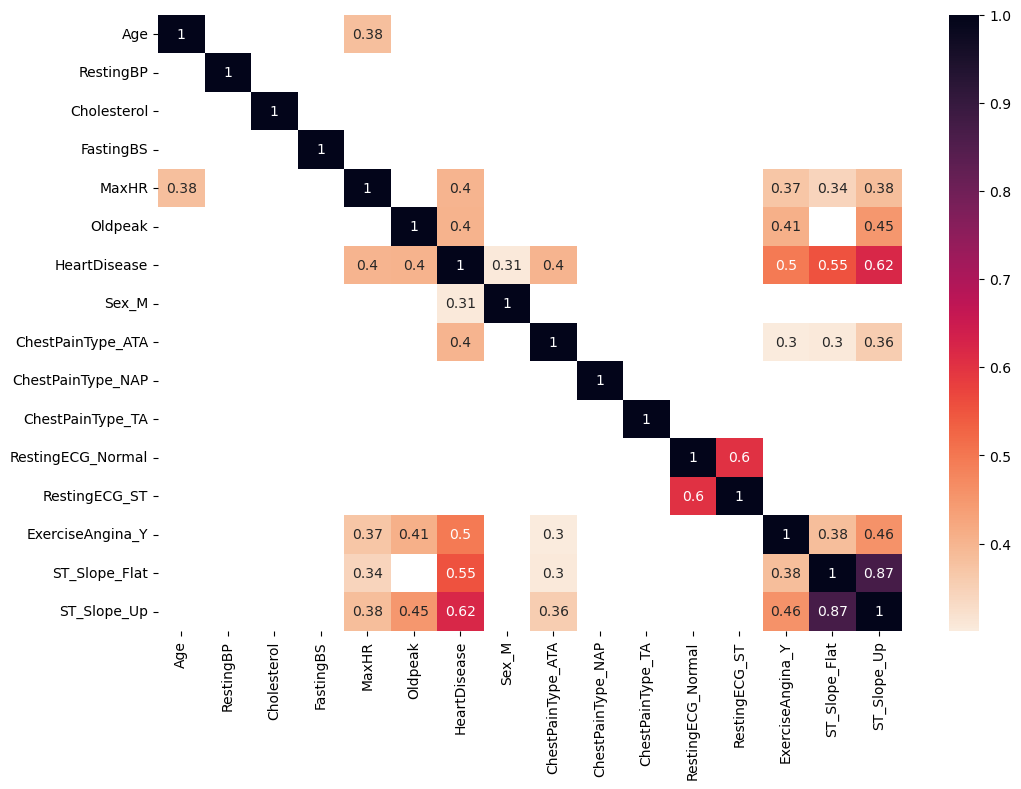

In [17]:
# Filter the correlation matrix to find features with high correlation
high_corr_features = correlations[correlations['HeartDisease'] > 0.3].index.tolist()
print("Features with high correlation to HeartDisease:")
for feature in high_corr_features:
    if feature != 'HeartDisease':
        print(feature)

plt.figure(figsize=(12,8))
sns.heatmap(correlations[correlations > 0.30], annot=True, cmap="rocket_r")
plt.show()

In [18]:
# Building a Single-Feature Classifier
x = heart_cleaned.drop(['HeartDisease'], axis=1)
y = heart_cleaned['HeartDisease']

x_train, x_val, y_train, y_val = train_test_split(x,y, test_size=0.15, random_state=417)

features = [
    'MaxHR',
    'Oldpeak',
    'Sex_M',
    'ChestPainType_ATA',
    'ExerciseAngina_Y',
    'ST_Slope_Flat',
    'ST_Slope_Up'
]

for feature in features:
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(x_train[[feature]], y_train)
    accuracy = knn.score(x_val[[feature]], y_val)
    print(f"The k-NN classifier trained on {feature} and with k=3 has an acacuracy of {accuracy*100:.2f}%")

The k-NN classifier trained on MaxHR and with k=3 has an acacuracy of 55.07%
The k-NN classifier trained on Oldpeak and with k=3 has an acacuracy of 58.70%
The k-NN classifier trained on Sex_M and with k=3 has an acacuracy of 61.59%
The k-NN classifier trained on ChestPainType_ATA and with k=3 has an acacuracy of 44.93%
The k-NN classifier trained on ExerciseAngina_Y and with k=3 has an acacuracy of 73.19%
The k-NN classifier trained on ST_Slope_Flat and with k=3 has an acacuracy of 81.88%
The k-NN classifier trained on ST_Slope_Up and with k=3 has an acacuracy of 55.07%


In [19]:
# Building a Multi-Feature Classifier
# Scale the features to the same range
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train[features])
x_val_scaled = scaler.transform(x_val[features])

# Build and evaluate the model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train_scaled, y_train)
accuracy = knn.score(x_val_scaled, y_val)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 85.51%


In [ ]:
# Hyperparameter Optimization
# Prepare the data for the final model
x = heart_cleaned.drop(['HeartDisease'], axis=1)
y = heart_cleaned['HeartDisease']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, random_state=417)

features = [
    'MaxHR',
    'Oldpeak',
    'Sex_M',
    'ChestPainType_ATA', # Tested whether this feature hindered accuracy, but it did not
    'ExerciseAngina_Y',
    'ST_Slope_Flat',
    'ST_Slope_Up'
]

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train[features])

# Define the hyperparameter grid
param_grid = {'n_neighbors': range(1, 20),
              'metric': ['minkowski', 'manhattan'],
            }

# Perform grid search with cross-validation
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, param_grid, scoring='accuracy')
knn_grid.fit(x_train_scaled, y_train)

# Print the best parameters and accuracy
print(f"Best score: {knn_grid.best_score_*100:.2f}%")
print(f"Best parameters: {knn_grid.best_params_}")

Best score: 84.08%
Best parameters: {'metric': 'minkowski', 'n_neighbors': 19}


In [26]:
# Model evaluation on test set
# Scale the test set
x_test_scaled = scaler.transform(x_test[features])

# Make predictions on the test set
predictions = knn_grid.best_estimator_.predict(x_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print(f"Model accuracy on test set: {accuracy*100:.2f}%")

Model accuracy on test set: 85.51%


In [27]:
# Check distribution of ChestPainType_ATA
print("Distribution of patients by ChestPainType_ATA in the entire dataset:")
print(x.ChestPainType_ATA.value_counts())

print("Distribution of patients by ChestPainType_ATA in the training set:")
print(x_train.ChestPainType_ATA.value_counts())

print("Distribution of patients by ChestPainType_ATA in the test set:")
print(x_test.ChestPainType_ATA.value_counts())

Distribution of patients by ChestPainType_ATA in the entire dataset:
ChestPainType_ATA
False    744
True     173
Name: count, dtype: int64
Distribution of patients by ChestPainType_ATA in the training set:
ChestPainType_ATA
False    635
True     144
Name: count, dtype: int64
Distribution of patients by ChestPainType_ATA in the test set:
ChestPainType_ATA
False    109
True      29
Name: count, dtype: int64


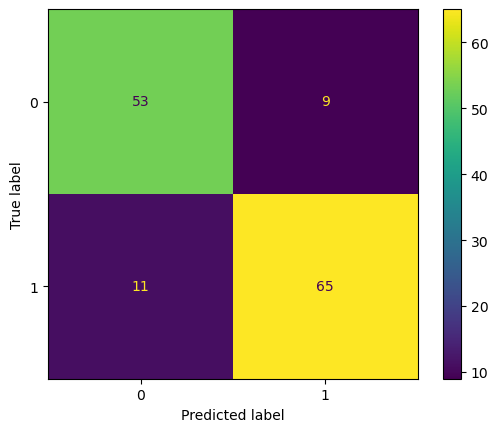

In [28]:
# Visualize the model's performance using a confusion matrix
cf = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cf).plot()
plt.show()

***True Negatives*** (top-left): 52 patients correctly predicted as not having heart disease.  
***False Positives*** (top-right): 10 patients incorrectly predicted as having heart disease.  
***False Negatives*** (bottom-left): 14 patients incorrectly predicted as not having heart disease.  
***True Positives*** (bottom-right): 62 patients correctly predicted as having heart disease.

My model correctly diagnoses patients with heart disease 85.5% of the time and misses diagnoses in 14.5% of patients.